# Instalacja Bibliotek

In [1]:
!pip install torchgeo
!pip install torch
!pip install pillow
!pip install matplotlib
!pip install numpy
!pip install tifffile


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Importy

In [2]:
# importy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tifffile as tiff
import torchgeo


/home/mikolaj/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Wyświetlenie przykładowego zdjęcia

#### https://earthexplorer.usgs.gov/

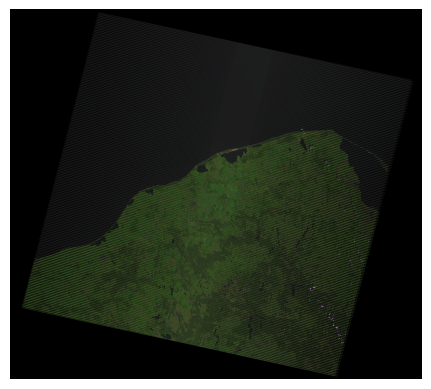

In [12]:
#tif_image = Image.open('Landsat/2019/LE07_L2SP_191022_20190415_20200827_02_T1_SR_B5.TIF')
# Ścieżki do plików z kanałami
band5_path = 'Landsat/2010/LE07_L2SP_191022_20100711_20200911_02_T1_SR_B5.TIF'  # Red
band4_path = 'Landsat/2010/LE07_L2SP_191022_20100711_20200911_02_T1_SR_B4.TIF'  # Green
band3_path = 'Landsat/2010/LE07_L2SP_191022_20100711_20200911_02_T1_SR_B3.TIF'  # Blue

# Otwórz kanały
band4 = tiff.imread(band5_path)
band3 = tiff.imread(band4_path)
band2 = tiff.imread(band3_path)

# Normalizacja kanałów (opcjonalnie, aby upewnić się, że wartości mieszczą się w zakresie 0-255)
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

band4 = normalize(band4)
band3 = normalize(band3)
band2 = normalize(band2)

# Stwórz obraz RGB
rgb_image = np.dstack((band4, band3, band2))

# Wyświetl obraz
plt.imshow(rgb_image)
plt.imsave('rgb_image.jpg', rgb_image)
plt.imsave('rgb_image.png', rgb_image)
plt.axis('off')  # Ukryj osie
plt.show()

In [64]:
# segmentacja wcztanego zdjęcia landsat przy pimocy torchgeo
#halo?
from torch.utils.data import DataLoader
from torchgeo.datasets import CDL, Landsat7, Landsat8, stack_samples
from torchgeo.samplers import RandomGeoSampler

import torchvision.transforms as T



In [84]:

landsat_dataset_2000 = Landsat7('Landsat/2000/')
landsat_dataset_2010 = Landsat7('Landsat/2010') # Wyświetl kanały
landsat_dataset_2019 = Landsat7('Landsat/2019/')

#łaczenie w jeden dataset
dataset = landsat_dataset_2010 | landsat_dataset_2019 | landsat_dataset_2000

transform = T.Compose([
    T.ToTensor(),
     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)



# Dodanie wytrenowanego modelu

https://pytorch.org/vision/stable/models.html

#### segmentacja semantyczna

In [25]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights
from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Step 1: Initialize model with the best available weights
weights = FCN_ResNet101_Weights.DEFAULT
model = fcn_resnet101(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
img = read_image('rgb_image.jpg')


batch = preprocess(img).unsqueeze(0)

with torch.no_grad():
    prediction = model(batch)["out"]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

class_names = ["land", "lake", "river", "forest", "city"]


for class_name in class_names:
    if class_name in class_to_idx:
        class_idx = class_to_idx[class_name]
        mask = normalized_masks[0, class_idx]
        to_pil_image(mask).show(title=class_name)
    else:
        print(f"Class '{class_name}' not found in the model's categories.")

Class 'land' not found in the model's categories.
Class 'lake' not found in the model's categories.
Class 'river' not found in the model's categories.
Class 'forest' not found in the model's categories.
Class 'city' not found in the model's categories.


#### Dokonuje klasyfikacji, ale do dopracowania

In [57]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn

# Ładowanie modelu ResNet50 wytrenowanego na ImageNet
model = models.resnet50(pretrained=True)

# Dostosowanie ostatniej warstwy do naszego zadania
num_classes = 10  # Zamień na liczbę klas w Twoim zadaniu
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Wczytanie wytrenowanych wag (jeśli posiadasz)
# model.load_state_dict(torch.load('path_to_your_model.pth'))  # Zamień 'path_to_your_model.pth' na ścieżkę do Twojego modelu
model.eval()

def load_and_preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(img_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Dodaj wymiar dla batch
    return image

class_names=[
    'land',
    'city',
    'forest',
    'water',
    'river',
    'lake',
    'wetland',
    'barren_land',
    'clouds',
    'snow'
]

img_path = 'rgb_image.jpg'  # Zamień 'path_to_your_image.jpg' na ścieżkę do Twojego obrazu
img_tensor = load_and_preprocess_image(img_path)

# Upewnij się, że obliczenia są wykonywane na CPU lub GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
img_tensor = img_tensor.to(device)

# Klasyfikacja obrazu
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted_class = torch.max(outputs, 1)

predicted_class_name = class_names[predicted_class.item()]
print(f"Predicted class: {predicted_class.item()}")
print(f"Predicted class: {predicted_class_name}")




cuda
Predicted class: 8
Predicted class: clouds


#### Notatki Oliwer

In [ ]:
from landsatxplore.api import API
from landsatxplore.earthexplorer import EarthExplorer
import os

# Dane logowania do USGS
username = 'Morpheus1024'
password = 'Niy$@Km!j6W2K9mzo5x#U@^#UzDFY#Bxb@sX%5PZwL2Pzc@GE33YhH4$cP'

# Inicjalizacja API
api = API(username, password)

# Wyszukiwanie scen Landsat 8
scenes = api.search(
    dataset='landsat_8_c1',
    latitude=52.2297,
    longitude=21.0122,
    start_date='2021-01-01',
    end_date='2021-12-31',
    max_cloud_cover=10
)

# Wypisanie znalezionych scen
for scene in scenes:
    print(scene['entity_id'], scene['acquisition_date'])

# Zamknięcie połączenia API
api.logout()

# Inicjalizacja EarthExplorer
ee = EarthExplorer(username, password)

# Pobieranie pierwszej znalezionej sceny
output_dir = 'landsat_data'
os.makedirs(output_dir, exist_ok=True)

if scenes:
    scene_id = scenes[0]['entity_id']
    ee.download(scene_id, output_dir=output_dir)

# Zamknięcie połączenia EarthExplorer
ee.logout()